## Machine Learning applied to identify Selective Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Selectivity model.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

convert_mic('>64')

100

In [3]:
# Load meta data
meta_data = pd.read_excel("data/Cumulative_Peptide_data_PG1.xlsx", index_col=0)
meta_data["MBC"] = [convert_mic(x) for x in meta_data["MBC"]]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276


In [4]:
# Create the new target selectivity
meta_data['selectivity'] = meta_data['MBC'] * meta_data['%Hemolysis']
meta_data['selectivity'] = np.log10(meta_data['selectivity'])
meta_data

,ID,Sequence,MBC,%Hemolysis,selectivity
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000,0.414973
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281,0.507122
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927,0.810760
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021,1.383924
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069,1.500266
...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367,3.549743
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085,3.564241
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292,3.666493
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276,3.709111


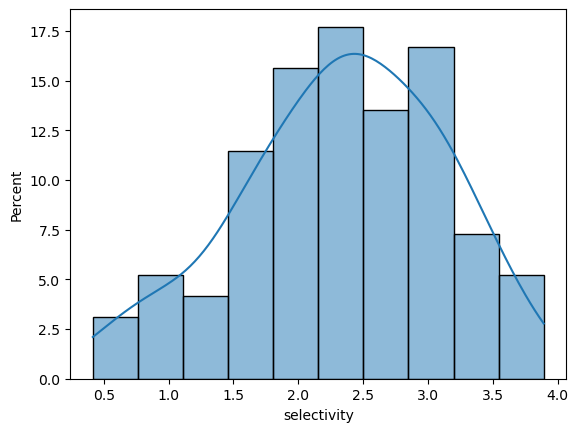

In [5]:
# target distribuition
sns.histplot(data=meta_data, x='selectivity', bins=10, kde=True, stat='percent')
plt.show()

## Embedding Extraction

The embeddings I used for the model were computed using the ESM-2 15B model and I used the mean of the last layer as the embedding.

Here's how to exytract them using the pre-trained model from esm2.  

Download the python file extract from [esm2-github](https://github.com/facebookresearch/esm), and make sure to have a conda enviromment seted up accordinly.

Then run:  
python extract.py esm2_t48_15B_UR50D data/Cumulative_Peptide_data_PG1.fasta data/embedding/esm2_15B_PG1 --repr_layers 48 --include mean

In [6]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
df

,ID,Sequence,MBC,%Hemolysis,selectivity,0,1,2,3,4,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000,0.414973,0.056671,-0.074099,-0.040746,0.217794,-0.197767,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281,0.507122,0.133009,-0.124348,-0.109747,0.222604,-0.261453,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927,0.810760,0.155696,-0.016959,-0.179328,0.153639,-0.241203,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021,1.383924,0.056310,-0.137829,-0.098538,0.162526,-0.252675,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069,1.500266,0.122564,-0.024471,-0.127546,0.165324,-0.258667,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367,3.549743,0.007245,-0.115889,-0.040796,0.235570,-0.216340,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085,3.564241,0.143025,-0.030791,-0.110694,0.109217,-0.223111,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292,3.666493,0.068697,-0.038422,-0.142241,0.184863,-0.232976,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276,3.709111,0.066839,-0.037917,-0.087912,0.137855,-0.218455,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [7]:
# Define target and features
target = df["selectivity"]

# define features
features = df.iloc[:,meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


## PCA from data before feature selection

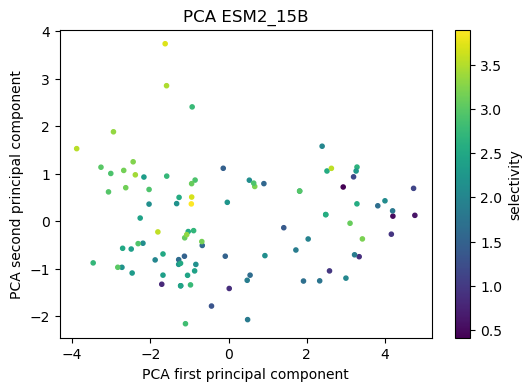

In [8]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(features)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=target, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='selectivity')
plt.show()

## Split data into train and test sets

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Selecting features by correlation only with the training set, to avoid any data leakage

In [10]:
def get_correlated_columns(df, target, threshold):
    # correlating train target  with train set
    corr_matrix = df.corrwith(target).abs().sort_values()

    # create a list of columns with high positive or negative correlation
    correlated_columns = []
    for column in corr_matrix.index:
        if (corr_matrix[column] >= threshold) & (column not in correlated_columns):
            correlated_columns.append(column)

    return(correlated_columns)

correlated_columns = get_correlated_columns(X_train, y_train, 0.6)
len(correlated_columns)

128

In [11]:
# #save the list to a file
# with open('models/correlated_columns_esm2_15B_hemolysis_corr06_new.pkl', 'wb') as f:
#     pickle.dump(correlated_columns, f)

# #load the list from the file
# with open('correlated_columns_esm2_15B_hemolysis_corr06_new.pkl', 'rb') as f:
#     correlated_columns = pickle.load(f)

# # #print the loaded list
# print(correlated_columns)

In [12]:
## filter train features and test by correlated columns with training
XX_train = X_train[correlated_columns]
XX_test = X_test[correlated_columns]
XX_train

,2666,5111,3870,1016,3386,4435,815,1672,5077,2693,...,3863,332,4468,1876,2290,312,3895,4707,1739,609
40,-0.014187,-0.178782,0.178048,0.000692,0.105029,-0.018662,-0.020276,-0.150536,-0.009108,-0.136206,...,-0.049222,-0.119446,-0.208459,0.198406,0.056002,-0.008329,0.049407,0.040958,-0.133535,-0.007682
67,-0.021352,-0.238943,0.192434,0.075445,0.136214,-0.044986,-0.037237,-0.134183,0.013246,-0.085328,...,-0.075702,-0.053916,-0.206557,0.184432,0.059182,-0.010665,-0.030321,0.018234,-0.047767,-0.004363
15,0.090114,-0.144120,0.148956,0.002892,0.119636,-0.023491,-0.055394,-0.128510,-0.035561,-0.178806,...,-0.005285,-0.126410,-0.311849,0.218399,0.049050,-0.050484,0.101655,0.097040,-0.161188,-0.043910
68,0.134366,-0.153887,0.104904,0.003912,0.085797,-0.042387,-0.068105,-0.159356,0.004583,-0.114383,...,-0.054417,-0.109563,-0.255652,0.267348,0.046142,-0.068633,0.031975,0.064362,-0.100661,-0.037965
88,0.119797,-0.127740,0.078799,-0.030375,0.114991,-0.042297,-0.040208,-0.202592,-0.076758,-0.103695,...,-0.067462,-0.109504,-0.209326,0.220891,0.046631,-0.050652,0.071591,0.049014,-0.104725,0.045136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.037247,-0.197836,0.151659,0.046064,0.135675,-0.007454,-0.034964,-0.122092,-0.047930,-0.107397,...,-0.085986,-0.096962,-0.180002,0.231000,0.035333,-0.017973,0.011775,0.047044,-0.088638,0.067948
71,0.005311,-0.240028,0.236695,0.122744,0.129574,-0.043482,-0.056753,-0.125051,-0.017500,-0.118272,...,-0.102949,-0.027187,-0.185913,0.180000,0.049572,-0.011847,0.009235,0.043196,-0.045567,0.020882
14,0.152513,-0.091944,0.092581,-0.040909,0.131212,-0.072692,-0.082078,-0.204996,0.004340,-0.151853,...,0.017587,-0.109968,-0.323788,0.286296,0.081945,-0.098558,0.144175,0.082935,-0.150265,-0.067039
92,-0.007955,-0.189840,0.259474,0.057658,0.118659,-0.040031,-0.034293,-0.136258,-0.016747,-0.087901,...,-0.079074,-0.071799,-0.183460,0.206244,0.037215,-0.016074,-0.003935,0.035611,-0.065023,0.038682


## data after feature selection

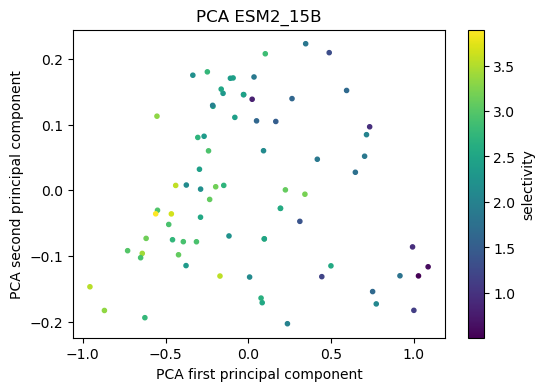

In [13]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(XX_train)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='selectivity')
plt.show()

## Running Regression Models

In [14]:
# store the results
results = pd.DataFrame()

# Create a list of models to test
models = [LinearRegression(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), SVR(), GradientBoostingRegressor(), XGBRegressor()]

# Create a dictionary of hyperparameters for each model
param_grid = [
    # LinearRegression
    {'fit_intercept': [True, False]}, 
    # Lasso
    {'alpha': np.arange(0.01, 1, 0.01),'max_iter': [10000, 100000]},
    # DecisionTreeRegressor
    {'max_depth': [None, 2, 3, 4, 5, 10], 'min_samples_leaf': [1,2,4]}, 
    # RandomForestRegressor
    {'n_estimators': [100, 200, 300, 500, 700], 'max_depth': [None, 2, 3, 4, 5, 10]}, 
    # SVR
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001]},
    # GradientBoostingRegressor
    {'n_estimators': [100, 200, 300, 500, 700], 'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [1, 3, 5], 'alpha': [0.1, 0.3, 0.6, 0.9]},
    # XGBRegressor
    {'n_estimators': [100, 300, 700], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [1, 3, 5]}
    ]

# Iterate over the models and fit and predict using grid search
for model, param_grid in zip(models, param_grid):
    # search and train
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=10, n_jobs=10)
    #grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=10, n_jobs=10)
    grid_search.fit(XX_train, y_train)
    
    # make predictions
    train_pred = grid_search.predict(XX_train)
    y_pred = grid_search.predict(XX_test)
    
    # Model evaluation on test data
    train_r2 = r2_score(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)

    # Model evaluation on test data
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)

    model_name = grid_search.best_estimator_.__class__.__name__
    embed_name = dir_path.split('/')[-2]
    best_params = str(grid_search.best_params_)
    
     # print best scores
    print(f"Model: {model_name}, Train R2:{train_r2:.2f}, Test R2:{test_r2:.2f}, best params {best_params}")

    # Saving results
    res_dict = {}
    res_dict["Embedding"] = embed_name
    res_dict["model"] = model_name
    # train scores
    res_dict["Train_R2_score"] = train_r2.round(2)
    res_dict["Train_MAE_score"] = train_mae.round(2)
    res_dict["Train_RMSE_score"] = train_rmse.round(2)

    # test scores
    res_dict["Test_R2_score"] = test_r2.round(2)
    res_dict["Test_MAE_score"] = test_mae.round(2)
    res_dict["Test_RMSE_score"] = test_rmse.round(2)
    res_dict["Test_Best_params"] = best_params
    
    # updating data frame with results
    results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)

#results.to_excel('results/results_regression_hemolysis_new.xlsx')

Model: LinearRegression, Train R2:0.99, Test R2:0.61, best params {'fit_intercept': False}
Model: Lasso, Train R2:0.64, Test R2:0.59, best params {'alpha': 0.01, 'max_iter': 10000}
Model: DecisionTreeRegressor, Train R2:0.76, Test R2:0.60, best params {'max_depth': 2, 'min_samples_leaf': 1}
Model: RandomForestRegressor, Train R2:0.95, Test R2:0.72, best params {'max_depth': None, 'n_estimators': 300}
Model: SVR, Train R2:0.96, Test R2:0.81, best params {'C': 1000, 'gamma': 0.1, 'kernel': 'poly'}
Model: GradientBoostingRegressor, Train R2:0.99, Test R2:0.76, best params {'alpha': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Model: XGBRegressor, Train R2:0.99, Test R2:0.79, best params {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700}


## Results Visualization

In [15]:
#results = pd.read_excel('results/results_regression_selectivity_new.xlsx', index_col=0)
results

,Embedding,model,Train_R2_score,Train_MAE_score,Train_RMSE_score,Test_R2_score,Test_MAE_score,Test_RMSE_score,Test_Best_params
0,esm2_15B_PG1,LinearRegression,0.99,0.02,0.07,0.61,0.49,0.56,{'fit_intercept': False}
1,esm2_15B_PG1,Lasso,0.64,0.34,0.44,0.59,0.44,0.58,"{'alpha': 0.01, 'max_iter': 10000}"
2,esm2_15B_PG1,DecisionTreeRegressor,0.76,0.28,0.36,0.60,0.43,0.57,"{'max_depth': 2, 'min_samples_leaf': 1}"
3,esm2_15B_PG1,RandomForestRegressor,0.95,0.13,0.16,0.72,0.37,0.48,"{'max_depth': None, 'n_estimators': 300}"
4,esm2_15B_PG1,SVR,0.96,0.12,0.15,0.81,0.28,0.40,"{'C': 1000, 'gamma': 0.1, 'kernel': 'poly'}"
5,esm2_15B_PG1,GradientBoostingRegressor,0.99,0.04,0.07,0.76,0.33,0.44,"{'alpha': 0.9, 'learning_rate': 0.05, 'max_dep..."
6,esm2_15B_PG1,XGBRegressor,0.99,0.03,0.07,0.79,0.31,0.41,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."


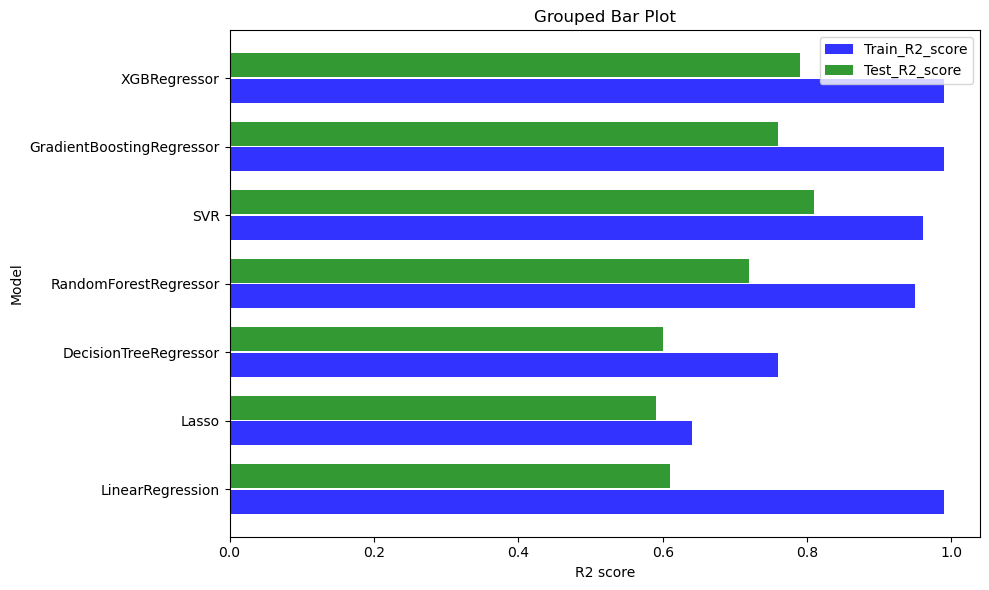

In [16]:
# Replace 'column1' and 'column2' with the names of the columns you want to plot
column1 = 'Train_R2_score'
column2 = 'Test_R2_score'

# Create a bar plot with two bars per group
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(results))
bar_height = 0.35
opacity = 0.8

# +/- 0.01 is to create a small space between bars
rects1 = ax.barh(y - bar_height/2 - 0.01, results[column1], bar_height, 
                 alpha=opacity, color='b', label=column1)
rects2 = ax.barh(y + bar_height/2 + 0.01, results[column2], bar_height,
                 alpha=opacity, color='g', label=column2)


# Add labels and legend
ax.set_ylabel('Model')
ax.set_xlabel('R2 score')
ax.set_title('Grouped Bar Plot')
ax.set_yticks(y)
ax.set_yticklabels(results['model'])
ax.legend()
plt.tight_layout()
plt.show()

## Fine Tunning Model with best hyperparameter found with Gridsearch


To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation. If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting. In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

The C parameter controls the trade-off between achieving a low training error and a low testing error. 

A linear kernel is a simple kernel function that can help to avoid overfitting by creating a linear decision boundary. 

### SVR

In [20]:
results.iloc[4, 8]

"{'C': 1000, 'gamma': 0.1, 'kernel': 'poly'}"

In [22]:
# train SVR on best parameters
model = SVR(
    kernel='poly',
    C=1000,
    gamma=0.1,
    max_iter=-1
)

# fiting
model.fit(XX_train, y_train)

# checking score
print(model.score(XX_train, y_train))
print(model.score(XX_test, y_test))

0.9576411211814889
0.8051136964829482


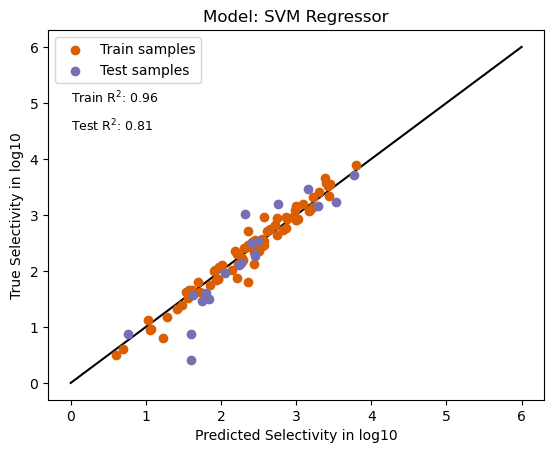

In [23]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Selectivity in log10")
plt.ylabel("True Selectivity in log10")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## Random Forest

In [24]:
results.iloc[3, 8]

"{'max_depth': None, 'n_estimators': 300}"

In [34]:
# train SVR on best parameters
model = RandomForestRegressor(
    max_depth=None, 
    n_estimators=300
)

# fiting
model.fit(XX_train, y_train)

# checking score
print(model.score(XX_train, y_train))
print(model.score(XX_test, y_test))

0.9469652638423973
0.7117535500013015


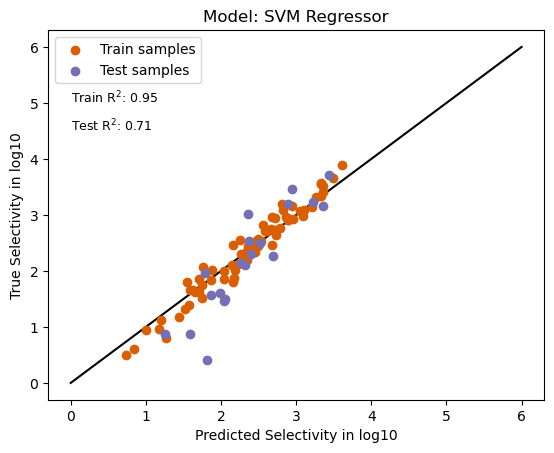

In [35]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Selectivity in log10")
plt.ylabel("True Selectivity in log10")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## GradientBoostingRegressor

In [28]:
results.iloc[5,8]

"{'alpha': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}"

In [36]:
# train a gradient boosting classifier
model = GradientBoostingRegressor(
    alpha=0.9, 
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100
    )

# fined tuned model performance
model.fit(XX_train, y_train)

# print R2 score
print(model.score(XX_train, y_train))
print(model.score(XX_test, y_test))

0.9900935227999074
0.7721385675654339


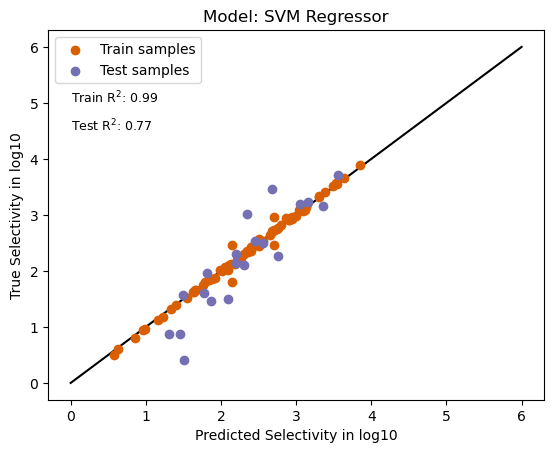

In [37]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Selectivity in log10")
plt.ylabel("True Selectivity in log10")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## XGBRegressor

In [31]:
results.iloc[6,8]

"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700}"

In [38]:
# train a gradient boosting classifier
model = XGBRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=700
    )

# fined tuned model performance
model.fit(XX_train, y_train)

# checking score
print(model.score(XX_train, y_train))
print(model.score(XX_test, y_test))

0.99075389716397
0.7923893152026475


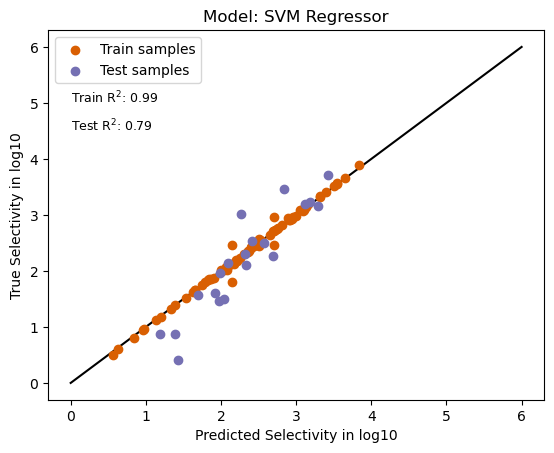

In [39]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Selectivity in log10")
plt.ylabel("True Selectivity in log10")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## save the model
SVR and lasso has less change to be overfitting

In [ ]:
#pickle.dump(SVR, open('models/SVM_reg_esm2_15B_selectivity_corr06.pkl', 'wb'))